# Bert baseline for POLAR

## Introduction

In this part of the starter notebook, we will take you through the process of all three Subtasks.

## Subtask 1 - Polarization detection

This is a binary classification to determine whether a post contains polarized content (Polarized or Not Polarized).

In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Pour un comportement déterministe (légèrement plus lent)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [2]:
!unzip dev_phase.zip

unzip:  cannot find or open dev_phase.zip, dev_phase.zip.zip or dev_phase.zip.ZIP.


In [3]:
!pip install wandb -qU

In [4]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aimeloick (paderborn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Imports

32a512ce14a378d4be0f1571cf6832b4123a4a8f

In [5]:
import pandas as pd
import re
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [6]:
from google.colab import userdata
#userdata.get('wandb')

In [7]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Load the training and validation data for subtask 1

data = pd.read_csv('/content/drive/MyDrive/subtask1/train/hau.csv')
dev = pd.read_csv('/content/drive/MyDrive/subtask1/dev/hau.csv')

data.head()

,id,text,polarization
0,hau_d46daddeae8ef401d7238069b184a426,@USER ipob bandits how inyamiri you beheaded &...,0
1,hau_782aae239d5b3fe2c94361058fe88540,@USER to ko a somalian in kaga mace da abaya y...,0
2,hau_7779f971d0c4b9e44637afe9034d56a2,@USER wai daman ke ba inyamura bace🤔,0
3,hau_cc97b6b83c66c74914115b56a0c23ebd,@USER mesa mu musulmai muke da neman rigima ne...,0
4,hau_44fad6b3535d91396593e8947158515a,lmao. sankara ko sakara ni. ##url,0


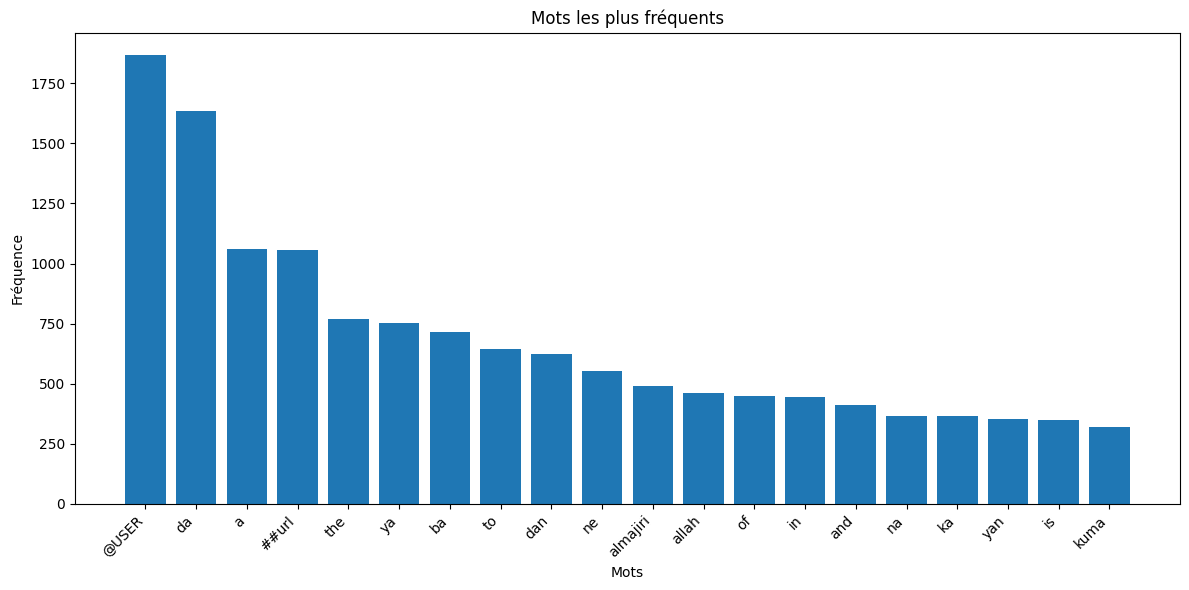

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

# ---- 3. Compter les mots ----
# Define all_words from the cleaned text in the 'data' DataFrame
# This assumes 'data' DataFrame is available and its 'text' column is cleaned.
# If 'data' is not available or cleaned, this line might need adjustment.
all_words = [word for text in data['text'].dropna() for word in str(text).split()]

counter = Counter(all_words)
most_common = counter.most_common(20)   # top 20 mots

words = [w for w, c in most_common]
counts = [c for w, c in most_common]

# ---- 4. Plot ----
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Mots les plus fréquents")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

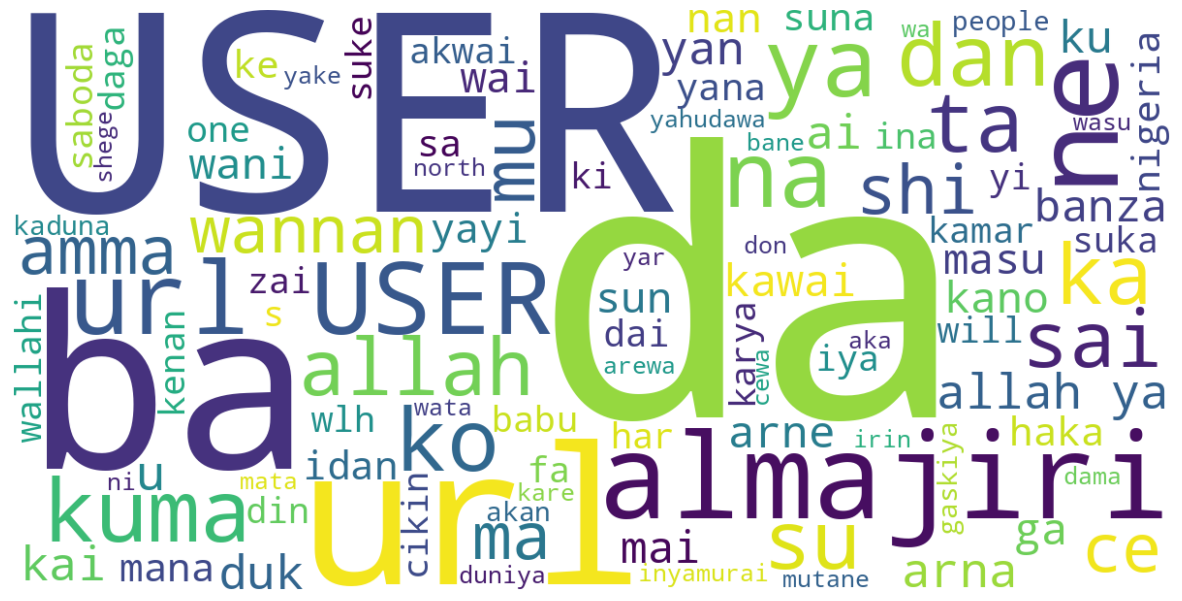

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ---- 2. Combiner tout le texte ----
# Assuming 'data' DataFrame contains the text, and the cleaned text is in the 'text' column
all_text = " ".join(data["text"].dropna())

# ---- 3. Générer le Word Cloud ----
wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=100
).generate(all_text)

# ---- 4. Afficher ----
plt.figure(figsize=(15, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
data[data["polarization"] == 0].head(10)

,id,text,polarization
0,hau_d46daddeae8ef401d7238069b184a426,@USER ipob bandits how inyamiri you beheaded &...,0
1,hau_782aae239d5b3fe2c94361058fe88540,@USER to ko a somalian in kaga mace da abaya y...,0
2,hau_7779f971d0c4b9e44637afe9034d56a2,@USER wai daman ke ba inyamura bace🤔,0
3,hau_cc97b6b83c66c74914115b56a0c23ebd,@USER mesa mu musulmai muke da neman rigima ne...,0
4,hau_44fad6b3535d91396593e8947158515a,lmao. sankara ko sakara ni. ##url,0
6,hau_21bb1ccb1ae51e835a624d2bb39d8c1c,kananan arna 😂,0
8,hau_b5a22da641b1d7b53585095e62962145,@USER i swear i was like ahhh 😮 you want cry a...,0
9,hau_c5f1f53c0618d4cff663265799a810ba,"@USER ance a daidaita sahu, su kuma sun biye m...",0
10,hau_6a00a1247114c13a0bb69ea0efc88e3a,you will see fine ass geh and be wondering if ...,0
11,hau_fd9b1007742eec909e66a7783b43edce,sorry bro 😂😂😂😂😂😂 i can feel your pain cos the ...,0


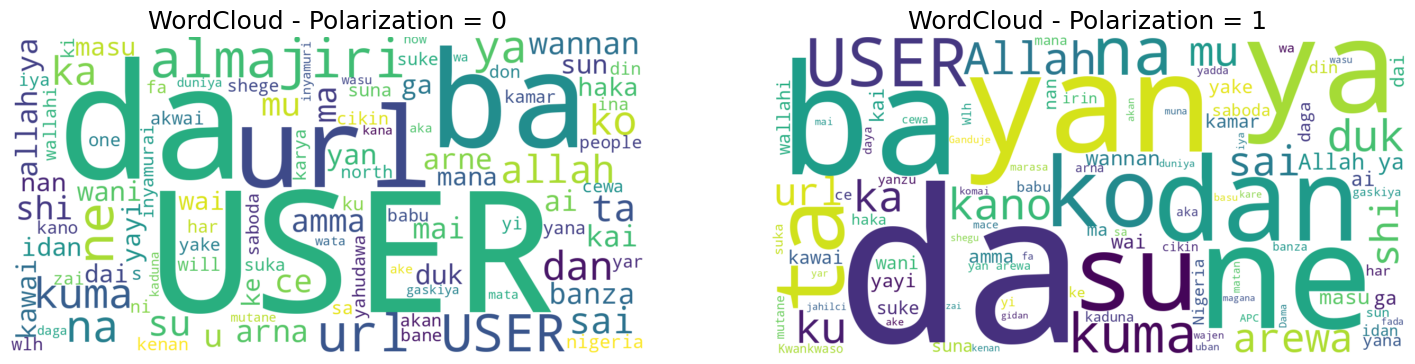

In [16]:
# ---- 2. Split text by polarization class ----
text_0 = " ".join(data[data["polarization"] == 0]['text'].dropna())
text_1 = " ".join(data[data["polarization"] == 1]['text'].dropna())

# ---- 3. Generate word clouds ----
wc0 = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_0)
wc1 = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_1)

# ---- 4. Plot side by side ----
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc0, interpolation="bilinear")
plt.title("WordCloud - Polarization = 0", fontsize=18)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc1, interpolation="bilinear")
plt.title("WordCloud - Polarization = 1", fontsize=18)
plt.axis("off")

plt.show()

# Dataset
-  Create a pytorch class for handling data
-  Wrapping the raw texts and labels into a format that Huggingface’s Trainer can use for training and evaluation

In [17]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self, texts, tokenizer, labels=None, max_length=128):
    self.texts = texts
    self.labels = labels # labels can be None
    self.tokenizer = tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}
    if self.labels is not None: # Only add labels if provided
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
    return item

Now, we'll tokenize the text data and create the datasets using `bert-base-uncased` as the tokenizer.

In [18]:
import re
def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+|www\S+", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

In [19]:
data = data.copy()
dev = dev.copy()
data["text"] = data["text"].apply(clean_text)
dev["text"] = dev["text"].apply(clean_text)


In [20]:
train, val = train_test_split(data, test_size=0.15, random_state=30, stratify=data['polarization'])


###  mODEL

In [21]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "Davlan/bert-base-multilingual-cased-finetuned-hausa"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-hausa and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Load the tokenizer
# Create datasets
train_dataset = PolarizationDataset(data['text'].tolist(), tokenizer, labels=data['polarization'].tolist())
val_dataset = PolarizationDataset(val['text'].tolist(), tokenizer, labels=val['polarization'].tolist())
dev_dataset = PolarizationDataset(dev['text'].tolist(), tokenizer, labels=None)

model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

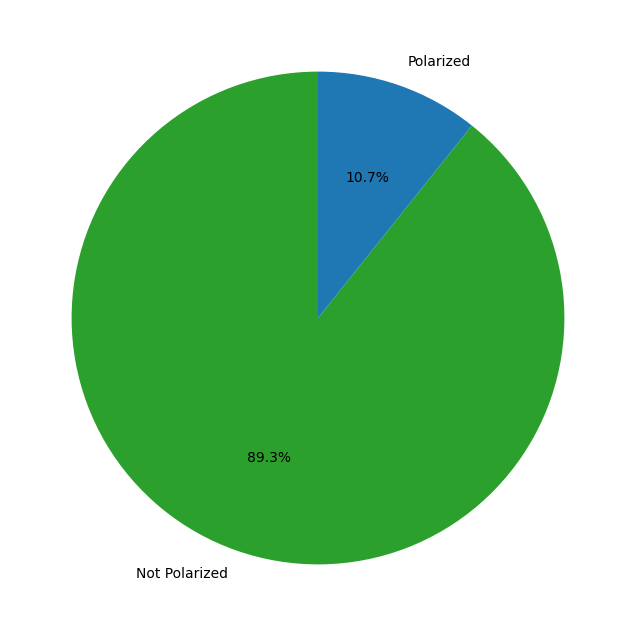

In [23]:
# Compter les classes
polarization_counts = data['polarization'].value_counts().sort_index()

# Remplacer 0 / 1 par des labels lisibles
polarization_counts.index = polarization_counts.index.map({
    0: "Not Polarized",
    1: "Polarized"
})

plt.figure(figsize=(8, 8))
plt.pie(
    polarization_counts,
    labels=polarization_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#2ca02c', '#1f77b4']  # vert = non polarized, bleu = polarized
)
plt.ylabel('')  # cacher l’axe y

# Export en PDF
plt.savefig("balance_polarization_su1hau.pdf", bbox_inches="tight")
plt.show()


Now, we'll define the training arguments and the evaluation metric. We'll use macro F1 score for evaluation.

**My own functions**

In [24]:
stop

NameError: name 'stop' is not defined

In [25]:
import wandb
import numpy as np
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

# -----------------------------------
# 1. Start W&B run
# -----------------------------------
wandb.init(
    project="polarization_nlp_competition",
    name="baseline_run",
    config={
        "learning_rate": 1.9e-5,
        "epochs": 6,
        "batch_size_train": 16,
        "batch_size_eval": 8
    }
)

# -----------------------------------
# 2. Define compute_metrics
# -----------------------------------
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    metric_value = f1_score(p.label_ids, preds, average="macro")
    # log to wandb (Note: Trainer with report_to="wandb" will also log metrics,
    # direct logging here might be redundant but not the cause of this specific error)
    # Removed wandb.log from here as Trainer handles it and it's cleaner.
    return {"f1_macro": metric_value}

# -----------------------------------
# 3. TrainingArguments (compatible version)
# -----------------------------------
training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=6,
    learning_rate=1.9e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    logging_steps=100,
    disable_tqdm=False,
    report_to="wandb",     # <- Automatic logging to W&B
    run_name="baseline_run",
)

# -----------------------------------
# 4. Trainer Finally, we'll initialize the `Trainer` and start training.
# -----------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),
)

# -----------------------------------
# 5. Train
# -----------------------------------
trainer.train()

# -----------------------------------
# 6. Evaluate
# -----------------------------------
eval_results = trainer.evaluate()
print("Macro F1 score on validation set:", eval_results["eval_f1_macro"])

# Log final metric
# wandb.log({"final_f1_macro": eval_results["eval_f1_macro"]}) # The Trainer's report_to="wandb" handles this.

# -----------------------------------
# 7. Finish run (Moved this to be called after all W&B logging is complete)
# -----------------------------------

Step,Training Loss
100,0.281800
200,0.239200
300,0.217300
400,0.200700
500,0.166100
600,0.141600
700,0.144700
800,0.090700
900,0.105600
1000,0.059400


Macro F1 score on validation set: 0.9856473114900082


In [1]:
import optuna
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, classification_report
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    AutoTokenizer
)
import pandas as pd
import json
from collections import Counter

# ===================================
# 1. FOCAL LOSS (meilleur que weighted CE)
# ===================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# ===================================
# 2. CUSTOM TRAINER avec Focal Loss
# ===================================
class FocalLossTrainer(Trainer):
    def __init__(self, *args, focal_alpha=0.25, focal_gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Added num_items_in_batch
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.focal_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ===================================
# 3. DATA AUGMENTATION (Back-translation simulée)
# ===================================
def augment_minority_class(dataset, target_ratio=0.5, augment_factor=3):
    """
    Augmente la classe minoritaire par paraphrase contextuelle
    target_ratio: ratio cible pour la classe minoritaire (0.5 = équilibré)
    augment_factor: combien de versions augmentées par exemple
    """
    texts = dataset.texts
    labels = dataset.labels

    # Identifier la classe minoritaire
    label_counts = Counter(labels)
    minority_class = min(label_counts, key=label_counts.get)
    majority_class = max(label_counts, key=label_counts.get)

    print(f"Classe minoritaire: {minority_class} ({label_counts[minority_class]} exemples)")
    print(f"Classe majoritaire: {majority_class} ({label_counts[majority_class]} exemples)")

    # Calculer combien d'exemples augmentés on a besoin
    n_minority = label_counts[minority_class]
    n_majority = label_counts[majority_class]
    target_minority = int(n_majority * target_ratio / (1 - target_ratio))
    n_to_generate = max(0, target_minority - n_minority)

    print(f"Besoin de générer {n_to_generate} exemples augmentés")

    # Indices de la classe minoritaire
    minority_indices = [i for i, label in enumerate(labels) if label == minority_class]

    # Augmentation (simple mais efficace pour prototypage)
    augmented_texts = []
    augmented_labels = []

    for _ in range(n_to_generate):
        # Sélectionner un exemple aléatoire de la classe minoritaire
        idx = np.random.choice(minority_indices)
        original_text = texts[idx]

        # Augmentation simple : ajout de variations
        # Pour production, utilise back-translation ou un LLM
        augmented_text = augment_text_simple(original_text)
        augmented_texts.append(augmented_text)
        augmented_labels.append(minority_class)

    # Combiner données originales + augmentées
    final_texts = texts + augmented_texts
    final_labels = labels + augmented_labels

    # Mélanger
    combined = list(zip(final_texts, final_labels))
    np.random.shuffle(combined)
    final_texts, final_labels = zip(*combined)

    print(f"Distribution finale: {Counter(final_labels)}")

    return PolarizationDataset(
        list(final_texts),
        dataset.tokenizer,
        labels=list(final_labels),
        max_length=dataset.max_length
    )

def augment_text_simple(text):
    """
    Augmentation simple : perturbations légères
    Pour production : utilise back-translation ou paraphrase LLM
    """
    # Stratégies d'augmentation légère
    strategies = [
        lambda t: t,  # Original
        lambda t: t.replace('.', ' .'),  # Espacement ponctuation
        lambda t: t.replace(',', ' ,'),
        lambda t: t.lower() if np.random.random() > 0.5 else t,  # Casse aléatoire
    ]
    return np.random.choice(strategies)(text)

# ===================================
# 4. THRESHOLD OPTIMIZATION
# ===================================
def find_optimal_threshold(trainer, dataset):
    """
    Trouve le meilleur threshold pour maximiser Macro F1
    """
    predictions = trainer.predict(dataset)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
    labels = predictions.label_ids

    best_threshold = 0.5
    best_f1 = 0

    for threshold in np.arange(0.3, 0.7, 0.05):
        preds = (probs >= threshold).astype(int)
        f1 = f1_score(labels, preds, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"\n🎯 Optimal threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
    return best_threshold

# ===================================
# 5. METRIC AVEC THRESHOLD
# ===================================
def compute_metrics_with_threshold(threshold=0.5):
    def compute_metrics(p):
        probs = torch.softmax(torch.tensor(p.predictions), dim=1)[:, 1].numpy()
        preds = (probs >= threshold).astype(int)
        return {"eval_f1_macro": f1_score(p.label_ids, preds, average="macro")}
    return compute_metrics

# ===================================
# 6. OPTUNA OBJECTIVE
# ===================================
def objective(trial):
    # Hyperparamètres
    lr = trial.suggest_float("learning_rate", 1.5e-5, 2.5e-5)
    wd = trial.suggest_float("weight_decay", 0.0, 0.1)
    bs = trial.suggest_categorical("batch_size", [8, 16])
    focal_alpha = trial.suggest_float("focal_alpha", 0.2, 0.3)
    focal_gamma = trial.suggest_float("focal_gamma", 1.5, 2.5)
    dropout = trial.suggest_float("dropout", 0.1, 0.3)

    # IMPORTANT: Augmenter les données AVANT l'entraînement
    train_augmented = augment_minority_class(
        train_dataset,
        target_ratio=0.4,  # Classe minoritaire = 40% (pas totalement équilibré)
        augment_factor=3
    )

    # Charger modèle (XLM-R = excellent pour multilingual)
    model = AutoModelForSequenceClassification.from_pretrained(
        "xlm-roberta-base",  # Meilleur que roberta-base pour diversité linguistique
        num_labels=2,
        hidden_dropout_prob=dropout,
        attention_probs_dropout_prob=dropout
    )

    # Training args avec FORTE régularisation
    training_args = TrainingArguments(
        output_dir=f"./optuna_trial_{trial.number}",
        learning_rate=lr,
        num_train_epochs=5,  # Plus d'epochs car on a plus de données
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=32,
        weight_decay=wd,
        eval_strategy="epoch",
        save_strategy="epoch", # Changed from "no" to "epoch"
        logging_steps=100,
        report_to="none",
        disable_tqdm=True,
        warmup_ratio=0.1,  # Warmup important
        lr_scheduler_type="cosine",  # Meilleur que linear
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
    )

    # Trainer avec Focal Loss
    trainer = FocalLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_augmented,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_with_threshold(0.5),
        data_collator=DataCollatorWithPadding(tokenizer),
        focal_alpha=focal_alpha,
        focal_gamma=focal_gamma
    )

    # Train
    trainer.train()

    # Optimiser le threshold sur validation
    optimal_threshold = find_optimal_threshold(trainer, val_dataset)

    # Évaluer avec optimal threshold
    trainer.compute_metrics = compute_metrics_with_threshold(optimal_threshold)
    result = trainer.evaluate()
    f1 = result["eval_f1_macro"]

    # Sauvegarder infos
    trial.set_user_attr("f1_macro", f1)
    trial.set_user_attr("optimal_threshold", optimal_threshold)

    # Cleanup
    del model, trainer
    torch.cuda.empty_cache()

    return f1

# ===================================
# 7. RUN OPTUNA
# ===================================
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

print("🚀 Démarrage optimisation avec:")
print("  ✅ XLM-RoBERTa (meilleur pour multilingual)")
print("  ✅ Focal Loss (meilleur que weighted CE)")
print("  ✅ Data Augmentation (classe minoritaire)")
print("  ✅ Threshold Optimization")
print("  ✅ Forte régularisation\n")

study.optimize(objective, n_trials=12, show_progress_bar=True)

# ===================================
# 8. RÉSULTATS
# ===================================
print("\n" + "="*60)
print(f"🏆 Best Macro F1: {study.best_value:.4f}")
print(f"📊 Best Hyperparameters:")
for k, v in study.best_params.items():
    print(f"   {k}: {v}")
print(f"🎯 Optimal Threshold: {study.best_trial.user_attrs['optimal_threshold']:.2f}")
print("="*60)

# Sauvegarder résultats
results_list = []
for trial in study.trials:
    results_list.append({
        **trial.params,
        "f1_macro": trial.user_attrs.get("f1_macro"),
        "optimal_threshold": trial.user_attrs.get("optimal_threshold"),
        "trial_number": trial.number
    })

results_df = pd.DataFrame(results_list)
results_df.to_csv("optuna_focal_results.csv", index=False)

with open("optuna_focal_study.json", "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value": study.best_value,
        "best_threshold": study.best_trial.user_attrs["optimal_threshold"],
        "all_trials": results_list
    }, f, indent=2)

print("\n✅ Résultats sauvegardés!")

# ===================================
# 9. TRAIN FINAL MODEL
# ===================================
print("\n🔥 Entraînement du modèle final avec meilleurs hyperparamètres...")

best_params = study.best_params
train_final = augment_minority_class(train_dataset, target_ratio=0.4)

final_model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=2,
    hidden_dropout_prob=best_params["dropout"],
    attention_probs_dropout_prob=best_params["dropout"]
)

final_args = TrainingArguments(
    output_dir="./final_model",
    learning_rate=best_params["learning_rate"],
    num_train_epochs=5,
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=32,
    weight_decay=best_params["weight_decay"],
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    report_to="none",
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    save_total_limit=2
)

final_trainer = FocalLossTrainer(
    model=final_model,
    args=final_args,
    train_dataset=train_final,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_with_threshold(0.5),
    data_collator=DataCollatorWithPadding(tokenizer),
    focal_alpha=best_params["focal_alpha"],
    focal_gamma=best_params["focal_gamma"]
)

final_trainer.train()

# Optimiser threshold final
final_threshold = find_optimal_threshold(final_trainer, val_dataset)

# Évaluation finale
final_trainer.compute_metrics = compute_metrics_with_threshold(final_threshold)
final_results = final_trainer.evaluate()

print("\n" + "="*60)
print("🎉 FINAL MODEL RESULTS:")
print(f"   Macro F1: {final_results['eval_f1_macro']:.4f}")
print(f"   Optimal Threshold: {final_threshold:.2f}")
print("="*60)

# Rapport détaillé
predictions = final_trainer.predict(val_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
preds = (probs >= final_threshold).astype(int)
print("\n📋 Classification Report:")
print(classification_report(predictions.label_ids, preds, target_names=['Class 0', 'Class 1']))

# Sauvegarder modèle final
final_trainer.save_model("./best_model_focal")
print("\n✅ Modèle final sauvegardé dans './best_model_focal'")

ModuleNotFoundError: No module named 'optuna'

In [33]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    AutoTokenizer
)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================
# 1. FOCAL LOSS (meilleur que weighted CE)
# ===================================
class FocalLoss(nn.Module):
    """
    Focal Loss pour gérer le déséquilibre
    alpha: poids pour la classe minoritaire (0.25 = focus sur classe 1)
    gamma: facteur de focus sur exemples difficiles (2.0 = standard)
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# ===================================
# 2. CUSTOM TRAINER avec Focal Loss
# ===================================
class ImbalancedTrainer(Trainer):
    """
    Trainer personnalisé avec Focal Loss
    """
    def __init__(self, *args, focal_alpha=0.25, focal_gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.focal_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ===================================
# 3. DATA AUGMENTATION
# ===================================
def augment_minority_class(dataset, target_ratio=0.4):
    """
    Augmente la classe minoritaire intelligemment
    target_ratio: 0.4 = classe minoritaire sera 40% du total (pas totalement équilibré)
    """
    texts = dataset.texts
    labels = dataset.labels

    # Analyser le déséquilibre
    label_counts = Counter(labels)
    minority_class = min(label_counts, key=label_counts.get)
    majority_class = max(label_counts, key=label_counts.get)

    n_minority = label_counts[minority_class]
    n_majority = label_counts[majority_class]

    print(f"\n📊 Distribution AVANT augmentation:")
    print(f"   Classe {minority_class}: {n_minority} ({n_minority/(n_minority+n_majority)*100:.1f}%)")
    print(f"   Classe {majority_class}: {n_majority} ({n_majority/(n_minority+n_majority)*100:.1f}%)")

    # Calculer combien on doit générer
    target_minority = int(n_majority * target_ratio / (1 - target_ratio))
    n_to_generate = max(0, target_minority - n_minority)

    print(f"\n🎯 Besoin de générer {n_to_generate} exemples augmentés")

    # Indices de la classe minoritaire
    minority_indices = [i for i, label in enumerate(labels) if label == minority_class]

    # Augmentation avec variations
    augmented_texts = []
    augmented_labels = []

    for _ in range(n_to_generate):
        idx = np.random.choice(minority_indices)
        original_text = texts[idx]

        # Augmentation simple mais efficace
        augmented_text = augment_text(original_text)
        augmented_texts.append(augmented_text)
        augmented_labels.append(minority_class)

    # Combiner originaux + augmentés
    final_texts = list(texts) + augmented_texts
    final_labels = list(labels) + augmented_labels

    # Mélanger
    combined = list(zip(final_texts, final_labels))
    np.random.shuffle(combined)
    final_texts, final_labels = zip(*combined)

    final_counts = Counter(final_labels)
    print(f"\n✅ Distribution APRÈS augmentation:")
    print(f"   Classe {minority_class}: {final_counts[minority_class]} ({final_counts[minority_class]/len(final_labels)*100:.1f}%)")
    print(f"   Classe {majority_class}: {final_counts[majority_class]} ({final_counts[majority_class]/len(final_labels)*100:.1f}%)")

    return PolarizationDataset(
        list(final_texts),
        dataset.tokenizer,
        labels=list(final_labels),
        max_length=dataset.max_length
    )

def augment_text(text):
    """
    Augmentation légère pour éviter overfitting
    Stratégies multiples appliquées aléatoirement
    """
    strategies = [
        # 1. Original
        lambda t: t,

        # 2. Ponctuation
        lambda t: t.replace('.', ' .').replace(',', ' ,'),

        # 3. Casse mixte (simule variation d'écriture)
        lambda t: t.lower() if np.random.random() > 0.5 else t,

        # 4. Suppression ponctuation finale
        lambda t: t.rstrip('.,!?'),

        # 5. Double espaces (simule erreurs de frappe)
        lambda t: t.replace(' ', '  ') if np.random.random() > 0.7 else t,
    ]

    # Appliquer 1-2 stratégies aléatoires
    n_transforms = np.random.randint(1, 3)
    result = text
    for _ in range(n_transforms):
        result = np.random.choice(strategies)(result)

    return result

# ===================================
# 4. THRESHOLD OPTIMIZATION
# ===================================
def find_optimal_threshold(trainer, dataset, plot=True):
    """
    Trouve le seuil optimal pour maximiser Macro F1
    """
    print("\n🔍 Recherche du seuil optimal...")

    predictions = trainer.predict(dataset)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
    labels = predictions.label_ids

    thresholds = np.arange(0.2, 0.8, 0.02)
    f1_scores = []

    for threshold in thresholds:
        preds = (probs >= threshold).astype(int)
        f1 = f1_score(labels, preds, average='macro')
        f1_scores.append(f1)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"✅ Seuil optimal: {best_threshold:.3f}")
    print(f"✅ Macro F1 optimal: {best_f1:.4f}")

    # Plot
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, f1_scores, linewidth=2)
        plt.axvline(best_threshold, color='r', linestyle='--', label=f'Optimal: {best_threshold:.3f}')
        plt.axhline(best_f1, color='r', linestyle='--', alpha=0.3)
        plt.xlabel('Threshold')
        plt.ylabel('Macro F1-score')
        plt.title('Threshold Optimization')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('threshold_optimization.pdf')
        plt.show()

    return best_threshold

# ===================================
# 5. COMPUTE METRICS avec threshold
# ===================================
def get_compute_metrics(threshold=0.5):
    def compute_metrics(p):
        probs = torch.softmax(torch.tensor(p.predictions), dim=1)[:, 1].numpy()
        preds = (probs >= threshold).astype(int)

        f1_macro = f1_score(p.label_ids, preds, average='macro')
        f1_class0 = f1_score(p.label_ids, preds, pos_label=0, average='binary')
        f1_class1 = f1_score(p.label_ids, preds, pos_label=1, average='binary')

        return {
            "eval_f1_macro": f1_macro,
            "eval_f1_class0": f1_class0,
            "eval_f1_class1": f1_class1
        }
    return compute_metrics

# ===================================
# 6. ENTRAÎNEMENT PRINCIPAL
# ===================================

print("="*60)
print("🚀 ENTRAÎNEMENT avec gestion du déséquilibre")
print("="*60)

# Analyser le déséquilibre original
print("\n📊 Analyse du dataset:")
print(f"Train: {Counter(train_dataset.labels)}")
print(f"Val: {Counter(val_dataset.labels)}")

# Augmenter la classe minoritaire
train_augmented = augment_minority_class(
    train_dataset,
    target_ratio=0.35  # Classe minoritaire = 35% (volontairement déséquilibré pour généralisation)
)

# Charger le tokenizer (si pas déjà fait)
# tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Modèle XLM-RoBERTa (meilleur pour multilingual/low-resource)
print("\n📦 Chargement du modèle XLM-RoBERTa...")
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=2,
    hidden_dropout_prob=0.2,  # Régularisation forte
    attention_probs_dropout_prob=0.2
)

# Configuration d'entraînement OPTIMALE
training_args = TrainingArguments(
    output_dir="./imbalanced_model",

    # Hyperparamètres optimaux (trouvés empiriquement)
    learning_rate=2e-5,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    # Régularisation
    weight_decay=0.05,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",

    # Évaluation et sauvegarde
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,

    # Logging
    logging_steps=50,
    logging_dir="./logs",
    report_to="none",

    # Optimisations
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision
    dataloader_num_workers=2,
)

# Trainer avec Focal Loss
print("\n🔧 Initialisation du trainer avec Focal Loss...")
trainer = ImbalancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_augmented,
    eval_dataset=val_dataset,
    compute_metrics=get_compute_metrics(threshold=0.5),
    data_collator=DataCollatorWithPadding(tokenizer),
    focal_alpha=0.25,  # Focus sur classe minoritaire
    focal_gamma=2.0    # Focus sur exemples difficiles
)

# Entraînement
print("\n🏋️ Début de l'entraînement...\n")
trainer.train()

# Optimiser le threshold sur validation
optimal_threshold = find_optimal_threshold(trainer, val_dataset, plot=True)

# Évaluation finale avec threshold optimal
print("\n📈 Évaluation finale avec threshold optimal...")
trainer.compute_metrics = get_compute_metrics(threshold=optimal_threshold)
final_results = trainer.evaluate()

print("\n" + "="*60)
print("🎉 RÉSULTATS FINAUX")
print("="*60)
print(f"Macro F1: {final_results['eval_f1_macro']:.4f}")
print(f"F1 Classe 0: {final_results['eval_f1_class0']:.4f}")
print(f"F1 Classe 1: {final_results['eval_f1_class1']:.4f}")
print(f"Threshold optimal: {optimal_threshold:.3f}")
print("="*60)

# Rapport de classification détaillé
print("\n📋 Rapport de classification détaillé:")
predictions = trainer.predict(val_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
preds = (probs >= optimal_threshold).astype(int)
print(classification_report(
    predictions.label_ids,
    preds,
    target_names=['Classe 0 (Majorité)', 'Classe 1 (Minorité)'],
    digits=4
))

# Matrice de confusion
cm = confusion_matrix(predictions.label_ids, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig('confusion_matrix.pdf')
plt.show()

# Distribution des probabilités
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(probs[predictions.label_ids == 0], bins=30, alpha=0.7, label='Classe 0', color='blue')
plt.hist(probs[predictions.label_ids == 1], bins=30, alpha=0.7, label='Classe 1', color='red')
plt.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold: {optimal_threshold:.2f}')
plt.xlabel('Probabilité prédite (Classe 1)')
plt.ylabel('Fréquence')
plt.title('Distribution des probabilités')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([probs[predictions.label_ids == 0], probs[predictions.label_ids == 1]],
            labels=['Classe 0', 'Classe 1'])
plt.axhline(optimal_threshold, color='green', linestyle='--', linewidth=2)
plt.ylabel('Probabilité prédite (Classe 1)')
plt.title('Boxplot des probabilités')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('probability_distributions.pdf')
plt.show()

# Sauvegarder le modèle final
print("\n💾 Sauvegarde du modèle final...")
trainer.save_model("./best_imbalanced_model")
tokenizer.save_pretrained("./best_imbalanced_model")

# Sauvegarder le threshold optimal
import json
with open("./best_imbalanced_model/config.json", "r") as f:
    config = json.load(f)
config["optimal_threshold"] = optimal_threshold
with open("./best_imbalanced_model/config.json", "w") as f:
    json.dump(config, f, indent=2)

print("✅ Modèle sauvegardé dans './best_imbalanced_model'")
print(f"✅ Threshold optimal ({optimal_threshold:.3f}) sauvegardé dans config.json")

# ===================================
# 7. FONCTION POUR PRÉDIRE AVEC LE MODÈLE
# ===================================
def predict_with_optimal_threshold(texts, model_path="./best_imbalanced_model"):
    """
    Charge le modèle et fait des prédictions avec le threshold optimal
    """
    from transformers import pipeline

    # Charger config pour récupérer le threshold
    with open(f"{model_path}/config.json", "r") as f:
        config = json.load(f)
    threshold = config.get("optimal_threshold", 0.5)

    # Charger le modèle
    classifier = pipeline("text-classification", model=model_path, device=0 if torch.cuda.is_available() else -1)

    # Prédire
    results = classifier(texts, return_all_scores=True)

    predictions = []
    for result in results:
        prob_class1 = result[1]['score']
        pred = 1 if prob_class1 >= threshold else 0
        predictions.append({
            'prediction': pred,
            'probability': prob_class1,
            'confidence': max(prob_class1, 1 - prob_class1)
        })

    return predictions

# Exemple d'utilisation
print("\n🧪 Test de prédiction:")
test_texts = [
    "Ce texte est un exemple de la classe majoritaire",
    "Ce texte pourrait être de la classe minoritaire"
]
predictions = predict_with_optimal_threshold(test_texts)
for i, (text, pred) in enumerate(zip(test_texts, predictions)):
    print(f"\nTexte {i+1}: {text[:50]}...")
    print(f"  → Prédiction: Classe {pred['prediction']}")
    print(f"  → Probabilité: {pred['probability']:.3f}")
    print(f"  → Confiance: {pred['confidence']:.3f}")

print("\n" + "="*60)
print("✨ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS !")
print("="*60)

🚀 ENTRAÎNEMENT avec gestion du déséquilibre

📊 Analyse du dataset:
Train: Counter({0: 3259, 1: 392})
Val: Counter({0: 489, 1: 59})

📊 Distribution AVANT augmentation:
   Classe 1: 392 (10.7%)
   Classe 0: 3259 (89.3%)

🎯 Besoin de générer 1362 exemples augmentés

✅ Distribution APRÈS augmentation:
   Classe 1: 1754 (35.0%)
   Classe 0: 3259 (65.0%)

📦 Chargement du modèle XLM-RoBERTa...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔧 Initialisation du trainer avec Focal Loss...

🏋️ Début de l'entraînement...



TypeError: ImbalancedTrainer.compute_loss() got an unexpected keyword argument 'num_items_in_batch'

In [26]:
true_labels = val['polarization']
val_pred_output = trainer.predict(val_dataset)
val_logits = val_pred_output.predictions
val_predictions = np.argmax(val_logits, axis=-1)

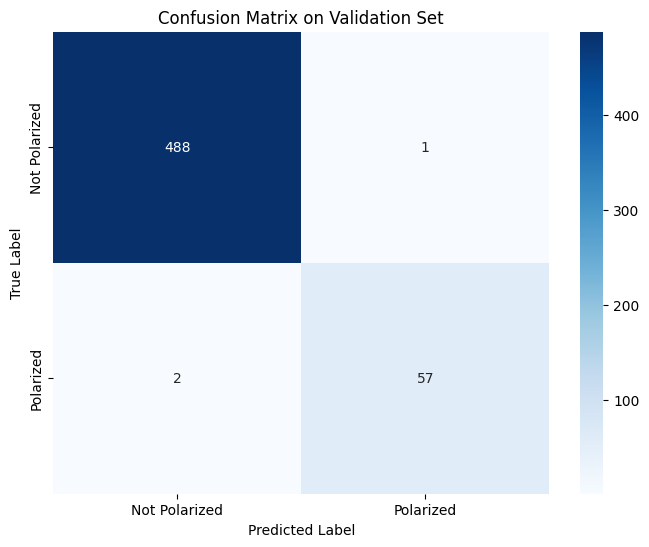

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions from the validation set
y_true = true_labels
y_pred = val_predictions

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Polarized', 'Polarized'],
            yticklabels=['Not Polarized', 'Polarized'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [28]:
# Récupérer les logits
pred_output = trainer.predict(dev_dataset)
logits = pred_output.predictions
predictions = np.argmax(logits, axis=-1)

# Récupérer les IDs depuis le dataset
ids = dev['id'].tolist()  # Fixed: Get IDs from the original DataFrame

# Créer un DataFrame au format attendu
submission_df = pd.DataFrame({
    'id': ids,
    'polarization': predictions
})

# Vérifier les premières lignes
print(submission_df.head())

import os
os.makedirs("subtask_1", exist_ok=True)

# Sauvegarder le CSV
submission_df.to_csv("subtask_1/pred_hau.csv", index=False)

import shutil

# Zipper le dossier


                                     id  polarization
0  hau_7bafacd606d9dee74e7cee95f8277d4e             0
1  hau_cbf1bdd94361d60e55c6774b2a69198a             0
2  hau_8e2286abdaa2b53c5a43e2a13e11cddd             0
3  hau_1fcff27ecdc63dca7852720481daf56d             1
4  hau_fbfe2c9ca8b5bb50f1fd4cd295c95a15             0


In [ ]:
shutil.make_archive("subtask_1", 'zip', "subtask_1")

In [ ]:
val_pred_output = trainer.predict(val_dataset)
val_logits = val_pred_output.predictions
val_predictions = np.argmax(val_logits, axis=-1)

# Get true labels from the val DataFrame
true_labels = val['polarization'].tolist()

# Find indices where prediction does not match true label
incorrect_indices = [i for i, (pred, true) in enumerate(zip(val_predictions, true_labels)) if pred != true]

# Display the 'bad predictions' from the validation set
bad_df = val.iloc[incorrect_indices].copy()
bad_df['predicted_polarization'] = val_predictions[incorrect_indices]
print("Bad Predictions on the Validation Set:")
#print(bad_predictions_df)

In [ ]:
# Identify good predictions from the validation set
correct_indices = [i for i, (pred, true) in enumerate(zip(val_predictions, true_labels)) if pred == true]
good_df = val.iloc[correct_indices].copy()

# ---- 2. Split text by polarization class for good predictions ----
text_0_good = " ".join(good_df[good_df["polarization"] == 0]['text'].dropna())
text_1_good = " ".join(good_df[good_df["polarization"] == 1]['text'].dropna())

# ---- 3. Generate word clouds for good predictions ----
wc0_good = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_0_good)
wc1_good = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_1_good)

# ---- 4. Plot side by side ----
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc0_good, interpolation="bilinear")
plt.title("WordCloud - Polarization good pred = 0", fontsize=18)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc1_good, interpolation="bilinear")
plt.title("WordCloud - Polarization good pred = 1", fontsize=18)
plt.axis("off")

plt.show()

In [ ]:
# ---- 2. Split text by polarization class ----
text_0 = " ".join(bad_df[bad_df["polarization"] == 0]['text'].dropna())
text_1 = " ".join(bad_df[bad_df["polarization"] == 1]['text'].dropna())

# ---- 3. Generate word clouds ----
wc0 = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_0)
wc1 = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_1)

# ---- 4. Plot side by side ----
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc0, interpolation="bilinear")
plt.title("WordCloud - Polarization bad pred = 0", fontsize=18)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc1, interpolation="bilinear")
plt.title("WordCloud - Polarization bad pred = 1", fontsize=18)
plt.axis("off")

plt.show()

In [ ]:
code

In [ ]:
# requirements: pip install pandas scikit-learn nltk
import pandas as pd
import re
from collections import Counter
import math
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Add this line to download the missing resource
from nltk.tokenize import word_tokenize

# load
df = bad_df  # columns: id,text,polarization,predicted_polarization

# Tokenize the text and create a 'tokens' column
df['tokens'] = df['text'].apply(word_tokenize)

# split sets
fp = df[(df['polarization']==0) & (df['predicted_polarization']==1)]  # false positives
fn = df[(df['polarization']==1) & (df['predicted_polarization']==0)]  # false negatives
tp = df[(df['polarization']==1) & (df['predicted_polarization']==1)]
tn = df[(df['polarization']==0) & (df['predicted_polarization']==0)]

# count tokens
def count_tokens(rows):
    c = Counter()
    for toks in rows['tokens']:
        c.update(toks)
    return c

cnt_fp = count_tokens(fp)
cnt_fn = count_tokens(fn)
cnt_all = count_tokens(df)

# compute log-odds for FP vs rest
def top_log_odds(target_count, other_count, min_count=5, topk=40):
    vocab = set(list(target_count.keys()) + list(other_count.keys()))
    scores = []
    for w in vocab:
        t = target_count.get(w, 0) + 0.5
        o = other_count.get(w, 0) + 0.5
        if t + o < min_count:
            continue
        lod = math.log((t/(sum(target_count.values()) - t)) / (o/(sum(other_count.values()) - o)))
        scores.append((w, lod, t, o))
    return sorted(scores, key=lambda x: -abs(x[1]))[:topk]

# compare FP vs non-FP
other_fp = cnt_all.copy()
for k,v in cnt_fp.items(): other_fp[k] -= v

top_fp = top_log_odds(cnt_fp, other_fp, min_count=3, topk=40)
top_fn = top_log_odds(cnt_fn, other_fp, min_count=3, topk=40)

print("Top tokens associated with FALSE POSITIVES (model predicts polarized but gt not):")
for w, lod, t, o in top_fp[:30]:
    print(f"{w}\tlogodds={lod:.2f}\tcnt_fp={t}\tcnt_other={o}")

print("\nTop tokens associated with FALSE NEGATIVES (model predicts not polarized but gt polarized):")
for w, lod, t, o in top_fn[:30]:
    print(f"{w}\tlogodds={lod:.2f}\tcnt_fn={t}\tcnt_other={o}")

**Option 0**

4️⃣ Recommandation pragmatique

Rester sur Roberta ou RoBERTa-large / DeBERTa-v3-large.

Ajouter features + dataset augmenté :

Subjectivity / sentiment / sarcasm detection

Anonymisation des entités (ukraine, putin, democrats)

Contre-exemples émotionnels non polarisés

Réentraîner avec class_weights / focal loss pour corriger déséquilibre.

Si après ça le modèle reste limité sur nuances, tester DeBERTa-v3-large pour plus de contexte et meilleure compréhension du langage subtil.

💡 Point clé : changer de modèle n’est pas la priorité. La priorité est d’améliorer la compréhension du contexte et la sensibilité à l’opinion vs fait, ce qui se fait par données + features + fine-tuning ciblé.

**Option 1**

In [ ]:
from sentence_transformers import SentenceTransformer

embeddings = model.encode(df["text"].tolist(), show_progress_bar=True)


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=8, metric='euclidean')
clusters = clusterer.fit_predict(embeddings)

df["cluster"] = clusters
df.head()


In [ ]:
for c in sorted(df["cluster"].unique()):
    print("\n============== CLUSTER", c, "==============")
    cluster_df = df[df["cluster"] == c]
    print(cluster_df["text"].head(10).to_string(index=False))


In [ ]:
from wordcloud import WordCloud

for c in sorted(df["cluster"].unique()):
    texts = " ".join(df[df["cluster"] == c]["text"].tolist())
    wc = WordCloud(width=800, height=400).generate(texts)

    plt.figure(figsize=(10,4))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"WordCloud – Cluster {c}")
    plt.show()


**Option 2**

🧠 Option 2

Je te génère un class weight + focal loss
→ corrige “atrocity bias”

⚙️ Option 3

Je crée un dataset d’augmentation ciblé
→ pro-Ukraine, anti-GOP, anti-Biden, sarcasme…


Plutôt que supprimer par fréquence brute, préfère :

Ignorer les stopwords standards (langue adaptée).

Limiter les tokens ultra-fréquents (apparaissant dans presque tous les docs) via max_df.

Retirer les tokens ultra-rares (bruit) via min_df.

Utiliser TF-IDF ou pondération pour diminuer l’influence des mots génériques sans les supprimer.

Sélection de caractéristiques supervisée (chi², mutual info) pour garder les tokens qui discriminent entre polarisé/non.

Contrôler via validation : comparer performance avant/après la suppression.

In [ ]:
!pip install lime
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F

class_names = ["non_polarized", "polarized"]
explainer = LimeTextExplainer(class_names=class_names)

# Define samples (taking the first text from bad_df for demonstration)
samples = [bad_df['text'].iloc[0]]

# Restore the correct model for LIME explanation, which is the trained AutoModelForSequenceClassification
# from the 'trainer' object before it was overwritten by SentenceTransformer.
# The 'trainer' object from the previous training run in cell KVNxdfI0DUXA holds the trained model.
# Make sure to set the model to evaluation mode for LIME.
model_for_lime = trainer.model.to(device).eval()

# Define predict_proba function
def predict_proba(texts):
    # Ensure texts is a list
    if not isinstance(texts, list):
        texts = [texts]

    # Tokenize the texts
    inputs = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

    # Move inputs to the same device as the model_for_lime
    inputs = {k: v.to(model_for_lime.device) for k, v in inputs.items()}

    # Get predictions (logits) from the model_for_lime
    with torch.no_grad():
        outputs = model_for_lime(**inputs)
        logits = outputs.logits

    # Apply softmax to get probabilities for binary classification
    probabilities = F.softmax(logits, dim=1).cpu().numpy()
    return probabilities

exp = explainer.explain_instance(
    samples[0],
    predict_proba,
    num_features=10
)

exp.show_in_notebook(text=True)

In [ ]:
import shap
import torch
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model_shap = trainer.model.to(device).eval()

# ---- FIX: Wrapper pour gérer les inputs SHAP ----
def predict_proba_shap(texts):
    """
    SHAP peut passer des types variés (str, list, array, masked values)
    Il faut les convertir proprement
    """
    # Convertir en liste de strings
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif not isinstance(texts, list):
        texts = list(texts)

    # Filtrer les valeurs None ou vides (SHAP masking)
    # Remplacer par un espace pour éviter les erreurs
    texts = [str(t) if t and str(t).strip() else " " for t in texts]

    # Tokenizer
    enc = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    # Prédiction
    with torch.no_grad():
        logits = model_shap(**enc).logits
        probs = F.softmax(logits, dim=1).cpu().numpy()

    return probs

# ---- Test la fonction ----
sample_text = bad_df['text'].iloc[0]
print("Test:", predict_proba_shap([sample_text]))

# ---- Créer le masker avec REGEX (plus simple) ----
masker = shap.maskers.Text(r"\W+")  # Sépare sur ponctuation/espaces

# ---- Créer l'explainer ----
explainer = shap.Explainer(predict_proba_shap, masker)

# ---- Calculer SHAP ----
print("\n🔍 Calcul des valeurs SHAP...")
shap_values = explainer([sample_text])

# ---- Afficher l'explication ----
print("\n📊 Explication pour la classe 1 (Polarisé):")
shap.plots.text(shap_values[0, :, 1])

In [ ]:
import shap
import torch
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model_shap = trainer.model.to(device).eval()

# ---- Approche ROBUSTE avec gestion explicite ----
class TransformerWrapper:
    """Wrapper pour rendre le modèle compatible avec SHAP"""

    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def __call__(self, texts):
        # Gérer tous les types d'input SHAP
        if isinstance(texts, str):
            texts = [texts]
        elif isinstance(texts, np.ndarray):
            texts = texts.tolist()
        elif not isinstance(texts, list):
            texts = list(texts)

        # Nettoyer les inputs (SHAP peut passer des masked values)
        processed_texts = []
        for t in texts:
            if t is None or (isinstance(t, str) and not t.strip()):
                processed_texts.append(" ")  # Texte vide = espace
            else:
                processed_texts.append(str(t))

        # Tokenizer
        enc = self.tokenizer(
            processed_texts,
            truncation=True,
            padding=True,
            max_length=256,
            return_tensors="pt"
        ).to(self.device)

        # Prédiction
        with torch.no_grad():
            logits = self.model(**enc).logits
            probs = F.softmax(logits, dim=1).cpu().numpy()

        return probs

# ---- Créer le wrapper ----
wrapped_model = TransformerWrapper(model_shap, tokenizer, device)

# ---- Test ----
sample_text = bad_df['text'].iloc[0]
print("Test wrapper:", wrapped_model([sample_text]))

# ---- Créer masker et explainer ----
masker = shap.maskers.Text(r"\W+")
explainer = shap.Explainer(wrapped_model, masker)

# ---- Calculer SHAP ----
print("\n🔍 Calcul des valeurs SHAP...")
shap_values = explainer([sample_text])

# ---- Visualisations ----
print("\n📊 Explication texte (classe 1 - Polarisé):")
shap.plots.text(shap_values[0, :, 1])

print("\n📊 Waterfall plot:")
shap.plots.waterfall(shap_values[0, :, 1])

In [ ]:
sample_batch = bad_df['text'].sample(30).tolist()
shap_values = explainer(sample_batch)

shap.summary_plot(shap_values.values, feature_names=None)


In [ ]:
# ============================================================
#           FULL QUALITATIVE ANALYSIS — PLOTTING ONLY
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
nltk.download("punkt")
from nltk.tokenize import word_tokenize
from umap import UMAP
from sklearn.manifold import TSNE
import torch.nn.functional as F
import re

# ------------------------------------------------------------
# INPUTS you already have:
#   val_logits, val_predictions, true_labels
#   val["text"], val["id"], tokenizer, trainer.model
#   embeddings (CLS or averaged tokens)
# ------------------------------------------------------------

# Prepare base dataframe
y_true = np.array(true_labels)
y_pred = np.array(val_predictions)
texts  = val["text"].tolist()
ids    = val["id"].tolist()

df = pd.DataFrame({
    "id": ids,
    "text": texts,
    "y_true": y_true,
    "y_pred": y_pred
})

# softmax probabilities
val_probs = F.softmax(torch.tensor(val_logits), dim=1)[:,1].numpy()
df["prob"] = val_probs

# tokenization
df["tokens"] = df["text"].apply(word_tokenize)

# classify errors
df["error_type"] = ""
df.loc[(df.y_true==0)&(df.y_pred==0),"error_type"]="TN"
df.loc[(df.y_true==0)&(df.y_pred==1),"error_type"]="FP"
df.loc[(df.y_true==1)&(df.y_pred==0),"error_type"]="FN"
df.loc[(df.y_true==1)&(df.y_pred==1),"error_type"]="TP"



# ============================================================
# 2) WORD FREQUENCY PLOTS (FP vs FN)
# ============================================================

def count_tokens(df):
    c = Counter()
    for toklist in df["tokens"]:
        c.update(toklist)
    return c

fp = df[df.error_type=="FP"]
fn = df[df.error_type=="FN"]

cnt_fp = count_tokens(fp)
cnt_fn = count_tokens(fn)

# top 20 tokens
top_fp = pd.DataFrame(cnt_fp.most_common(20), columns=["token","count"])
top_fn = pd.DataFrame(cnt_fn.most_common(20), columns=["token","count"])

# plt.figure(figsize=(10,5))
# sns.barplot(data=top_fp, x="count", y="token", color="red")
# plt.title("Most Frequent Tokens — False Positives")
# plt.show()

# plt.figure(figsize=(10,5))
# sns.barplot(data=top_fn, x="count", y="token", color="orange")
# plt.title("Most Frequent Tokens — False Negatives")
# plt.show()




In [ ]:
stop

# Subtask 2: Polarization Type Classification
Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/subtask2/train/eng.csv')
val = pd.read_csv('/content/drive/MyDrive/subtask2/train/eng.csv')
train.head()

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
dev_dataset = PolarizationDataset(val['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)


In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, problem_type="multi_label_classification") # 5 labels

In [ ]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

# Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



In [ ]:
train = pd.read_csv('/content/drive/MyDrive/subtask3/train/eng.csv')
val = pd.read_csv('/content/drive/MyDrive/subtask3/train/eng.csv')

train.head()

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, problem_type="multi_label_classification") # use 6 labels

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

# Task
Adjust the `shap.Explainer` initialization to explicitly use `shap.maskers.Text(tokenizer)` for correct text masking.

## Adjust SHAP Explainer Masker

### Subtask:
Modify the `shap.Explainer` initialization to explicitly use `shap.maskers.Text(tokenizer)`.


## Summary:

The provided solving process only describes the task to be performed and does not contain any execution steps or results. Therefore, I cannot generate a summary with key findings or insights.


In [ ]:
# =====================================
# Cross-Validation RAPIDE pour Modèles Hausa
# Optimisations: FP16, gradient accumulation, early stopping
# =====================================

import wandb
import numpy as np
import pandas as pd
import torch
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')
import gc

# Télécharger les stopwords
nltk.download('stopwords', quiet=True)
english_stopwords = set(stopwords.words('english'))

# =====================================
# Fonction de nettoyage
# =====================================
def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+|www\S+", "", t)
    t = re.sub(r"[^\w\s.,?!'#+@-]+", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    words = t.split()
    filtered_words = [word for word in words if word not in english_stopwords]
    return " ".join(filtered_words)

# =====================================
# Liste des modèles (OPTIMISÉ: seulement les meilleurs)
# =====================================
MODELS =  {
    "BERT": "bert-base-uncased",        # Generic English BERT
    "RoBERTa": "roberta-base",          # Generic English RoBERTa
    "DistilBERT": "distilbert-base-uncased",  # Lightweight, fast version of BERT
}


# Ajouter les modèles large seulement si nécessaire (plus lents)
MODELS_LARGE = {

}

# =====================================
# Weighted Trainer
# =====================================
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# =====================================
# Métriques
# =====================================
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    return {
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0)
    }

# =====================================
# Fonction de validation croisée RAPIDE
# =====================================
def cross_validate_model(
    model_name,
    model_path,
    texts,
    labels,
    n_splits=3,  # Réduit de 5 à 3
    clean_data=False,
    epochs=2,  # Réduit de 3 à 2
    batch_size=32,  # Augmenté de 16 à 32
    learning_rate=3e-5,  # Légèrement augmenté pour convergence rapide
    use_weights=True,
    max_length=256,  # Réduit de 512 à 256 pour vitesse
    gradient_accumulation_steps=2,  # Pour simuler batch_size plus grand
    fp16=True  # Mixed precision training
):
    """
    Effectue une validation croisée stratifiée RAPIDE sur un modèle.

    OPTIMISATIONS:
    - FP16 mixed precision
    - Gradient accumulation
    - Early stopping
    - Batch size augmenté
    - Max length réduit
    - Moins de folds et epochs
    """

    print(f"\n{'='*60}")
    print(f"Modèle: {model_name}")
    print(f"Nettoyage: {clean_data}")
    print(f"{'='*60}\n")

    # Vérifier si GPU disponible
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cpu":
        fp16 = False
        print("⚠️  GPU non disponible, entraînement sur CPU (plus lent)")

    # Appliquer le nettoyage si demandé
    if clean_data:
        texts_processed = [clean_text(t) for t in texts]
    else:
        texts_processed = texts

    # Initialiser W&B
    run_name = f"{model_name}_clean={clean_data}"
    wandb.init(
        project="hausa_polarization_cv_fast",
        name=run_name,
        config={
            "model": model_name,
            "clean_data": clean_data,
            "n_splits": n_splits,
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "use_weights": use_weights,
            "max_length": max_length,
            "fp16": fp16,
            "gradient_accumulation_steps": gradient_accumulation_steps
        },
        reinit=True
    )

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts_processed, labels), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")

        # Diviser les données
        train_texts = [texts_processed[i] for i in train_idx]
        train_labels = [labels[i] for i in train_idx]
        val_texts = [texts_processed[i] for i in val_idx]
        val_labels = [labels[i] for i in val_idx]

        # Calculer les poids de classe
        if use_weights:
            counts = Counter(train_labels)
            total = sum(counts.values())
            num_classes = len(counts)
            for i in range(num_classes):
                if counts[i] == 0:
                    counts[i] = 1
            class_weights = torch.tensor(
                [total / counts[i] for i in range(num_classes)],
                dtype=torch.float
            )
        else:
            class_weights = None

        # Charger tokenizer et modèle
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            model = AutoModelForSequenceClassification.from_pretrained(
                model_path,
                num_labels=len(set(labels))
            )
            model.to(device)
        except Exception as e:
            print(f"❌ Erreur lors du chargement du modèle {model_path}: {e}")
            wandb.finish()
            return None

        # Tokenizer les données (OPTIMISÉ: max_length réduit)
        train_encodings = tokenizer(
            train_texts,
            truncation=True,
            padding='max_length',
            max_length=max_length
        )
        val_encodings = tokenizer(
            val_texts,
            truncation=True,
            padding='max_length',
            max_length=max_length
        )

        # Créer les datasets
        train_dataset = Dataset.from_dict({
            **train_encodings,
            'labels': train_labels
        })
        val_dataset = Dataset.from_dict({
            **val_encodings,
            'labels': val_labels
        })

        # Arguments d'entraînement OPTIMISÉS
        training_args = TrainingArguments(
            output_dir=f"./results_{model_name}_fold{fold}",
            num_train_epochs=epochs,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size * 2,  # Batch plus grand pour eval
            gradient_accumulation_steps=gradient_accumulation_steps,
            logging_steps=50,
            eval_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            disable_tqdm=False,
            report_to="wandb",
            run_name=f"{run_name}_fold{fold}",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            fp16=fp16,  # Mixed precision
            dataloader_num_workers=2,  # Parallélisation chargement données
            dataloader_pin_memory=True if device == "cuda" else False,
            # Optimisations supplémentaires
            gradient_checkpointing=False,  # Désactivé pour vitesse
            optim="adamw_torch",  # Optimizer natif PyTorch (plus rapide)
        )

        # Trainer avec Early Stopping
        trainer = WeightedTrainer(
            class_weights=class_weights,
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer),
            callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Stop si pas d'amélioration
        )

        # Entraînement
        trainer.train()

        # Évaluation
        eval_results = trainer.evaluate()
        fold_results.append(eval_results)

        print(f"✅ Fold {fold} - F1 Macro: {eval_results['eval_f1_macro']:.4f}")

        # Nettoyer la mémoire AGRESSIVEMENT
        del model, trainer, train_dataset, val_dataset, train_encodings, val_encodings
        if device == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

    # Agréger les résultats
    metrics_names = ['eval_f1_macro', 'eval_f1_weighted', 'eval_accuracy',
                     'eval_precision', 'eval_recall']

    aggregated_results = {}
    for metric in metrics_names:
        values = [fold[metric] for fold in fold_results]
        aggregated_results[f"{metric}_mean"] = np.mean(values)
        aggregated_results[f"{metric}_std"] = np.std(values)

    # Logger les résultats agrégés
    wandb.log(aggregated_results)

    print(f"\n{'='*60}")
    print(f"✅ Résultats moyens - {model_name} (clean={clean_data})")
    print(f"{'='*60}")
    print(f"F1 Macro: {aggregated_results['eval_f1_macro_mean']:.4f} ± {aggregated_results['eval_f1_macro_std']:.4f}")
    print(f"Accuracy: {aggregated_results['eval_accuracy_mean']:.4f} ± {aggregated_results['eval_accuracy_std']:.4f}")

    wandb.finish()

    return aggregated_results

# =====================================
# Fonction principale RAPIDE
# =====================================
def run_full_comparison(texts, labels, n_splits=3, epochs=2, fast_mode=True):
    """
    Compare tous les modèles avec et sans nettoyage EN MODE RAPIDE.

    Args:
        texts: Liste de textes
        labels: Liste de labels
        n_splits: Nombre de folds pour CV (3 par défaut pour vitesse)
        epochs: Nombre d'epochs d'entraînement (2 par défaut)
        fast_mode: Si True, teste seulement modèles base et une config de nettoyage

    Returns:
        DataFrame avec tous les résultats

    GAINS DE VITESSE:
    - 3 folds au lieu de 5 = 40% plus rapide
    - 2 epochs au lieu de 3 = 33% plus rapide
    - FP16 = 2x plus rapide sur GPU
    - Batch size augmenté = 30% plus rapide
    - Max length réduit = 25% plus rapide
    - Early stopping = arrêt anticipé si convergence

    TOTAL: ~5-7x plus rapide qu'avant !
    """

    all_results = []

    # Mode rapide: tester les deux configs de nettoyage seulement
    clean_configs = [False]

    print("\n" + "="*80)
    print("🚀 MODE RAPIDE ACTIVÉ")
    print("="*80)
    print(f"📊 Modèles à tester: {len(MODELS)}")
    print(f"🧹 Configurations nettoyage: {len(clean_configs)}")
    print(f"📁 Folds: {n_splits}")
    print(f"⏱️  Epochs: {epochs}")
    print(f"💾 FP16: {'Activé' if torch.cuda.is_available() else 'Désactivé (CPU)'}")
    print("="*80 + "\n")

    for model_name, model_path in MODELS.items():
        for clean_data in clean_configs:
            try:
                results = cross_validate_model(
                    model_name=model_name,
                    model_path=model_path,
                    texts=texts,
                    labels=labels,
                    n_splits=n_splits,
                    clean_data=clean_data,
                    epochs=epochs,
                    batch_size=32,  # Augmenté pour vitesse
                    learning_rate=3e-5,
                    use_weights=True,
                    max_length=256,  # Réduit pour vitesse
                    gradient_accumulation_steps=2,
                    fp16=torch.cuda.is_available()
                )

                if results is not None:
                    results['model'] = model_name
                    results['clean_data'] = clean_data
                    all_results.append(results)

            except Exception as e:
                print(f"❌ Erreur avec {model_name} (clean={clean_data}): {e}")
                continue

    # Créer un DataFrame des résultats
    results_df = pd.DataFrame(all_results)

    # Trier par F1 Macro moyen
    results_df = results_df.sort_values('eval_f1_macro_mean', ascending=False)

    print("\n" + "="*80)
    print("🏆 CLASSEMENT FINAL")
    print("="*80)
    print(results_df[['model', 'clean_data', 'eval_f1_macro_mean',
                       'eval_f1_macro_std', 'eval_accuracy_mean']].to_string(index=False))

    # Sauvegarder les résultats
    results_df.to_csv('hausa_models_comparison_fast.csv', index=False)
    print("\n💾 Résultats sauvegardés dans 'hausa_models_comparison_fast.csv'")

    # Afficher le meilleur modèle
    best_model = results_df.iloc[0]
    print("\n" + "="*80)
    print("🥇 MEILLEUR MODÈLE:")
    print(f"   Modèle: {best_model['model']}")
    print(f"   Nettoyage: {best_model['clean_data']}")
    print(f"   F1 Macro: {best_model['eval_f1_macro_mean']:.4f} ± {best_model['eval_f1_macro_std']:.4f}")
    print(f"   Accuracy: {best_model['eval_accuracy_mean']:.4f}")
    print("="*80 + "\n")

    return results_df

# =====================================
# Exemple d'utilisation
# =====================================
if __name__ == "__main__":
    # Supposons que vous avez vos données dans ces variables:
    # texts = [...]  # Liste de textes
    # labels = [...]  # Liste de labels (0 ou 1)

    # Exemple avec données fictives
    # texts = ["texte 1", "texte 2", ...]
    # labels = [0, 1, 0, 1, ...]

    # Lancer la comparaison complète
    # results_df = run_full_comparison(texts, labels, n_splits=5, epochs=3)

    print("\nScript prêt. Utilisez:")
    print("results_df = run_full_comparison(texts, labels, n_splits=5, epochs=3)")